In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_rel

from utils import *

%load_ext autoreload
%autoreload 2
sns.set_context("talk")


## Load in

In [76]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "avg_medicare_beneficiaries_py",
    "beneficiary_avg_age",
    "avg_number_female_beneficiaries_py",
    "pct_beneficiaries_arthritis",
    # "pct_beneficiaries_afib",
    "pct_beneficiaries_alzheimers",
    # "pct_beneficiaries_cancer",
    # "pct_beneficiaries_chronic_kidney_disease",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_depression",
    "pct_beneficiaries_diabetes",
    # "pct_beneficiaries_osteoporosis",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_psychotic_disorders",
    "pct_beneficiaries_stroke",
    "avg_number_beneficiaries_medicare_medicaid_py",
    # "avg_number_beneficiaries_medicare_only_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_hispanic_beneficiaries_py",
]

df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

df.dropna(inplace=True)
# query for hf

df = df.query("condition_name == 'Heart Failure'")

In [77]:
# calculate readmission rate & drop the original columns
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df.drop(
    columns=["number_of_readmissions", "number_of_discharges"],
    inplace=True,
)

df["pct_female"] = (
    100 * df["avg_number_female_beneficiaries_py"] / df["avg_medicare_beneficiaries_py"]
)

df["pct_black"] = (
    100 * df["avg_number_black_beneficiaries_py"] / df["avg_medicare_beneficiaries_py"]
)
df["pct_white"] = (
    100 * df["avg_number_white_beneficiaries_py"] / df["avg_medicare_beneficiaries_py"]
)

df["pct_non_white"] = 100 - df.pct_white
df["pct_hispanic"] = (
    100
    * df["avg_number_hispanic_beneficiaries_py"]
    / df["avg_medicare_beneficiaries_py"]
)
df["pct_medicare_medicaid"] = (
    100
    * df["avg_number_beneficiaries_medicare_medicaid_py"]
    / df["avg_medicare_beneficiaries_py"]
)


# df["payment"] = df.payment.str.replace("$", "").str.replace(",", "").astype(float)

In [78]:
model_df = df.drop(
    columns=[
        "condition_name",
        "avg_medicare_beneficiaries_py",
        "avg_number_female_beneficiaries_py",
        "avg_number_white_beneficiaries_py",
        "avg_number_black_beneficiaries_py",
        "avg_number_hispanic_beneficiaries_py",
        "avg_number_beneficiaries_medicare_medicaid_py",
        "pct_white",
        # "pct_black",
        # "pct_hispanic",
        "pct_non_white",
    ]
)

model_df.dropna(inplace=True)

In [70]:
# right skewed dist -> log transform
# log_transform = [
#     "pct_beneficiaries_psychotic_disorders",
#     "pct_black",
#     "pct_hispanic",
#     # "pct_non_white",
# ]

# # power_transform = ["pct_medicare_only"]

# for col in log_transform:
#     model_df[col] = np.log10(model_df[col])
# for col in power_transform:
#     df[col] = np.power(df[col], 2)

## Feature Evaluation

In [79]:
X = model_df.drop(columns=["readmission_rate"])
y = model_df["readmission_rate"]
X_standardized = process_features(
    X,
    numeric_cols=X.columns,
    # numeric_cols=X.drop(columns=["condition_name"]).columns,
    # cat_cols=["condition_name"],
)
X_standardized.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X_w_bias = sm.add_constant(X_standardized)
linear_model = sm.OLS(y, X_w_bias)
linear_model = linear_model.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     57.11
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          8.05e-134
Time:                        14:06:21   Log-Likelihood:                -5060.3
No. Observations:                1919   AIC:                         1.015e+04
Df Residuals:                    1904   BIC:                         1.023e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         21.5303      0.077    277.919      0.000      21.378      21.682
beneficiary_avg_age                           -0.9447      0.154     -6.129      0.000      -1.247      -0.642
pct_beneficiaries_alzheimers                   0.7484      0.182      4.113      0.000       0.391       1.105
pct_beneficiaries_congestive_heart_failure    -0.3771      0.137     -2.758      0.006      -0.645      -0.109
pct_beneficiaries_copd                         0.6106      0.120      5.090      0.000       0.375       0.846
pct_beneficiaries_depression                  -0.4623      0.133     -3.465      0.001      -0.724      -0.201
pct_beneficiaries_diabetes                    -0.0067      0.183     -0.037      0.971      -0.365       0.352
pct_beneficiaries_ischemic_heart_disease       0.6579      0.128      5.120      0.000       0.406       0.910
pct_beneficiaries_arthritis                    0.2002      0.103      1.947      0.052      -0.001       0.402
pct_beneficiaries_psychotic_disorders          0.3065      0.160      1.918      0.055      -0.007       0.620
pct_beneficiaries_stroke                       0.3789      0.103      3.691      0.000       0.178       0.580
pct_female                                     0.3345      0.113      2.949      0.003       0.112       0.557
pct_black                                      0.2907      0.140      2.083      0.037       0.017       0.564
pct_hispanic                                   0.1170      0.126      0.927      0.354      -0.130       0.364
pct_medicare_medicaid                          0.4420      0.155      2.860      0.004       0.139       0.745
==============================================================================
Omnibus:                       66.367   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.210
Skew:                           0.251   Prob(JB):                     6.47e-28
Kurtosis:                       4.146   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
get_significant_variables(linear_model)

Index(['beneficiary_avg_age', 'pct_beneficiaries_alzheimers',
       'pct_beneficiaries_congestive_heart_failure', 'pct_beneficiaries_copd',
       'pct_beneficiaries_depression',
       'pct_beneficiaries_ischemic_heart_disease', 'pct_beneficiaries_stroke',
       'pct_female', 'pct_black', 'pct_medicare_medicaid'],
      dtype='object')

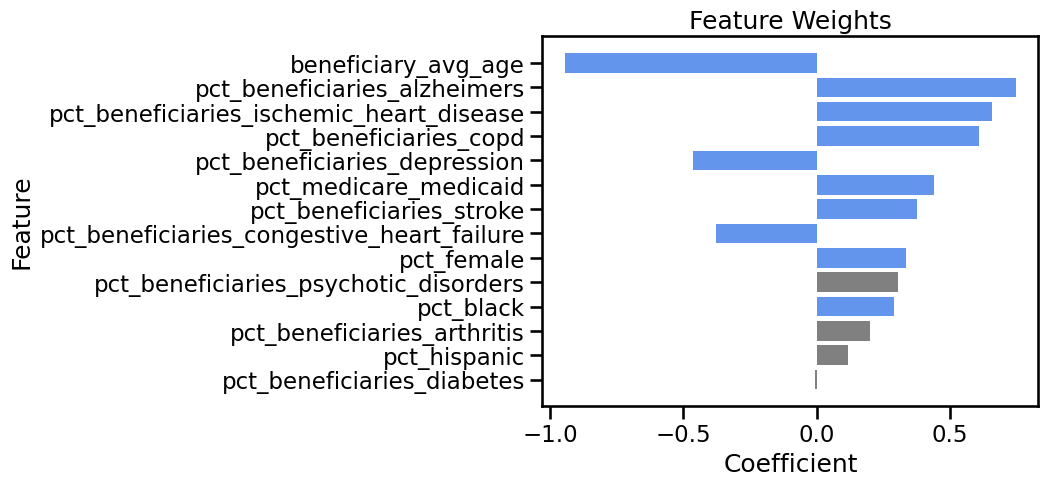

In [81]:
plot_feature_weights_horizontal_sm(linear_model)

Text(0.5, 1.0, 'Feature Weights')

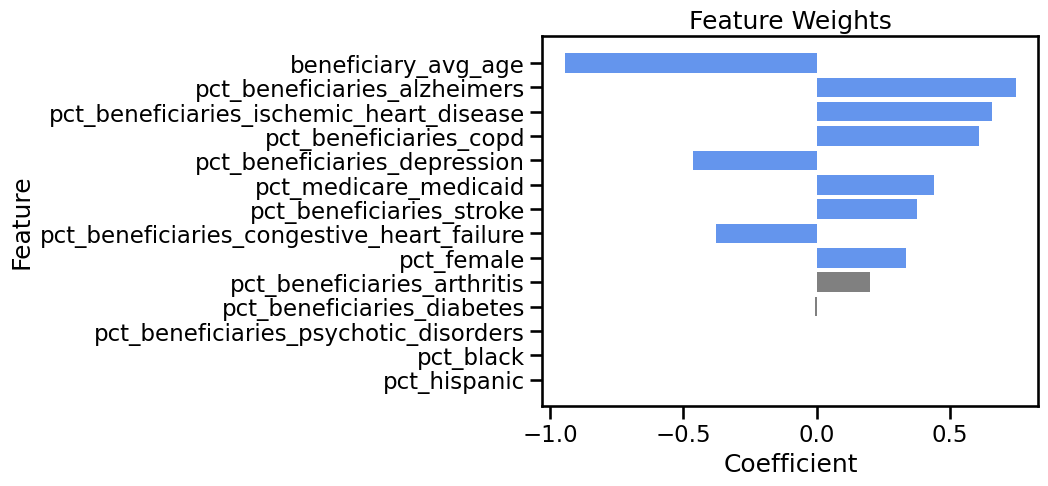

In [82]:
feature_names = linear_model.params.index[1:]  # Exclude the bias term
coefficients = linear_model.params[1:]

re_transformed_coefficeints = []
for fn in feature_names:
    if fn in log_transform:
        re_transformed_coefficeints.append(coefficients[fn] / 100)
    else:
        re_transformed_coefficeints.append(coefficients[fn])
re_transformed_coefficeints = np.array(re_transformed_coefficeints)

# # Sort feature names and coefficients based on absolute coefficient values
sorted_indices = np.argsort(np.abs(re_transformed_coefficeints))
feature_names_sorted = feature_names[sorted_indices]
coefficients_sorted = re_transformed_coefficeints[sorted_indices]

significant_variables = get_significant_variables(linear_model)
# Set the color for significant and non-significant variables
colors = [
    "cornflowerblue" if var in significant_variables else "gray"
    for var in feature_names
]
colors = [colors[i] for i in sorted_indices]

# Plot the feature weights
fig, ax = plt.subplots()
ax.barh(feature_names_sorted, coefficients_sorted, color=colors)

# Set labels and title
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Feature Weights")

In [86]:
sns.heatmap

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

<Axes: >

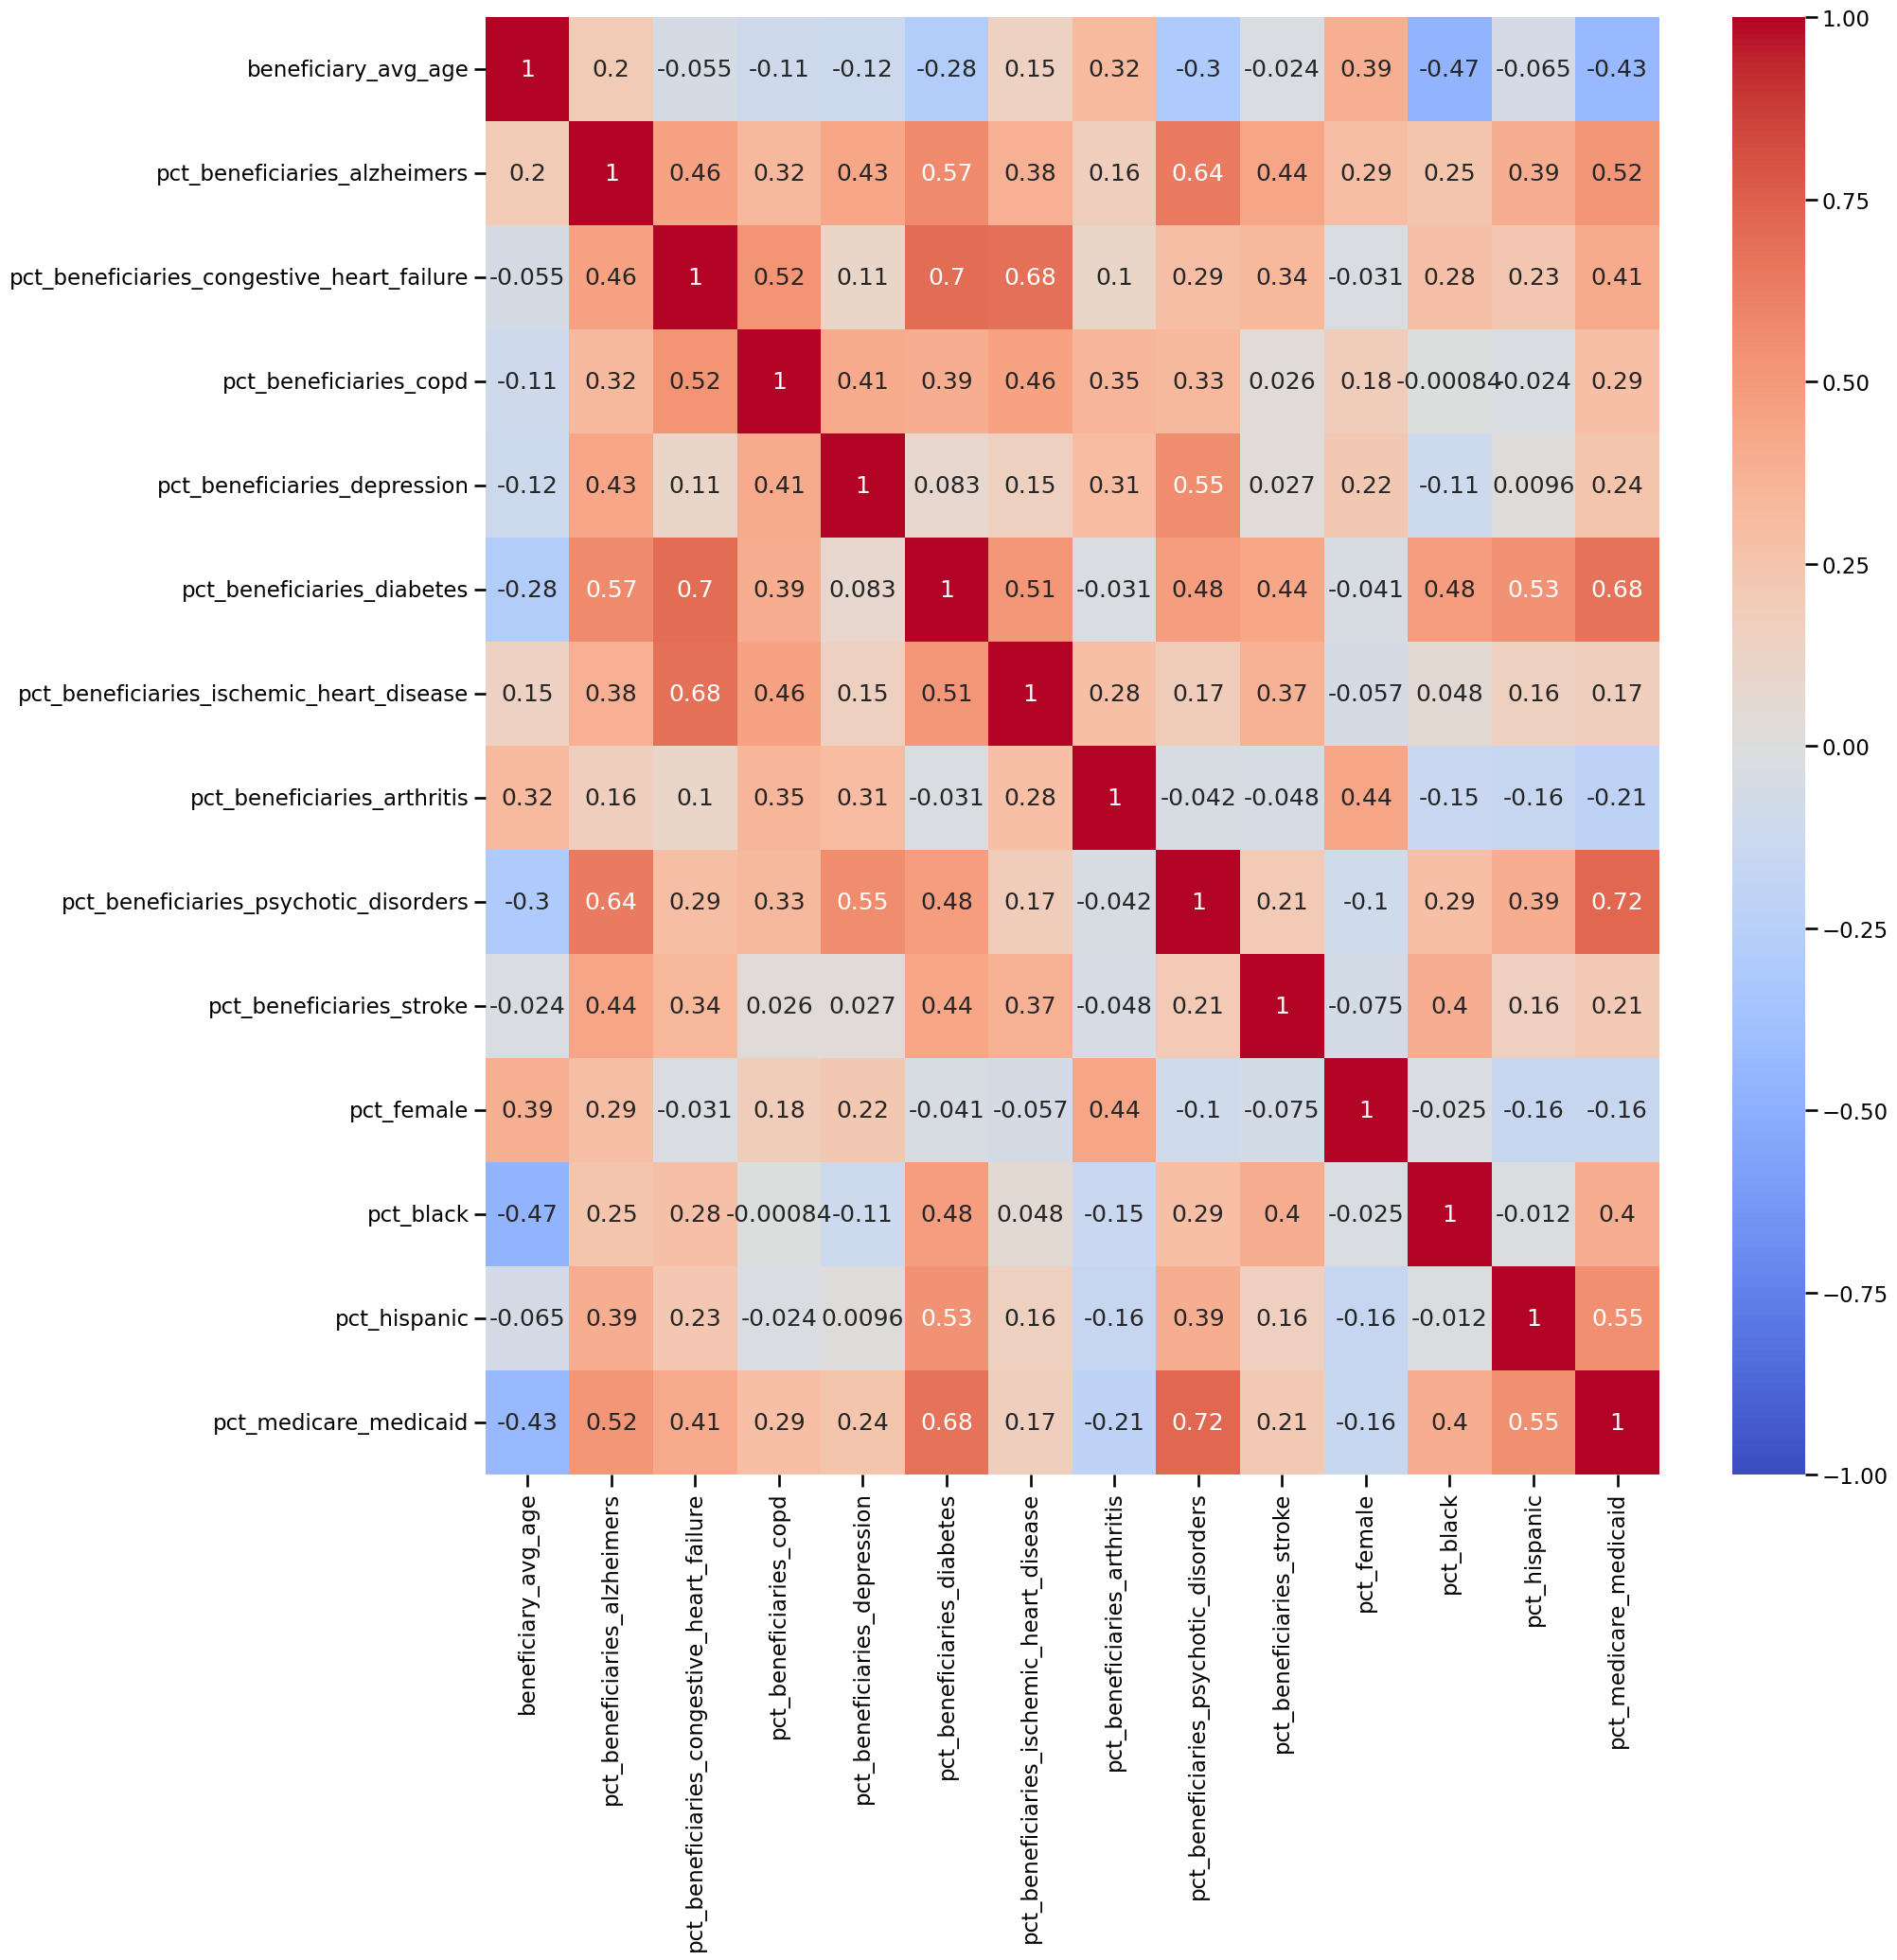

In [88]:
corr = X_standardized.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    corr,             #data  
    annot=True,       # show correlation values text in each cell
    cmap="coolwarm",  # pallette (diverging for + and -)
    vmin=-1,          # optional minimum value for color bar (defaults to data min)
    vmax=1,           # optional maximum value for color bar (defaults to data max)
    ax=ax             # axis to plot to
)

## Model prediction


In [496]:
from sklearn.model_selection import LeaveOneOut

### With race

In [605]:
results = []

for i, (train_index, test_index) in enumerate(loo.split(X_standardized)):
    X_train, X_test = X_standardized.iloc[train_index], X_standardized.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_w_bias = sm.add_constant(X_train)
    linear_model = sm.OLS(y_train, X_train_w_bias)
    linear_model = linear_model.fit()

    X_test_w_bias = sm.add_constant(X_test, has_constant="add")
    predicted_value = linear_model.predict(X_test_w_bias)

    mse = mean_squared_error([y_test.iloc[0]], [predicted_value.values[0]])
    r_squared = linear_model.rsquared
    adj_r_squared = linear_model.rsquared_adj

    # Store the results for each iteration in a dictionary
    result_dict = {
        "ModelName": "base + race",
        "Iteration": i,
        "R-squared": r_squared,
        "MSE": mse,
        "Adjusted R-squared": adj_r_squared,
    }

    # Append the result dictionary to the list
    results.append(result_dict)

# Combine the list of dictionaries into a DataFrame
results_df = pd.concat(
    [pd.DataFrame(result_dict, index=[0]) for result_dict in results],
    ignore_index=True,
)

### Without Race


In [606]:
X_standardized.columns

Index(['beneficiary_avg_age', 'pct_beneficiaries_alzheimers',
       'pct_beneficiaries_congestive_heart_failure', 'pct_beneficiaries_copd',
       'pct_beneficiaries_depression', 'pct_beneficiaries_diabetes',
       'pct_beneficiaries_ischemic_heart_disease',
       'pct_beneficiaries_arthritis', 'pct_beneficiaries_psychotic_disorders',
       'pct_beneficiaries_stroke', 'pct_female', 'pct_black', 'pct_hispanic',
       'pct_medicare_medicaid'],
      dtype='object')

In [609]:
X_standardized_no_race = X_standardized.drop(columns=["pct_black", "pct_hispanic"])

results = []

for i, (train_index, test_index) in enumerate(loo.split(X_standardized_no_race)):
    X_train, X_test = (
        X_standardized_no_race.iloc[train_index],
        X_standardized_no_race.iloc[test_index],
    )
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_w_bias = sm.add_constant(X_train)
    linear_model = sm.OLS(y_train, X_train_w_bias)
    linear_model = linear_model.fit()

    X_test_w_bias = sm.add_constant(X_test, has_constant="add")
    predicted_value = linear_model.predict(X_test_w_bias)

    mse = np.mean((y_test.values[0] - predicted_value.values[0]) ** 2)
    r_squared = linear_model.rsquared
    adj_r_squared = linear_model.rsquared_adj

    # Store the results for each iteration in a dictionary
    result_dict = {
        "ModelName": "base",
        "Iteration": i,
        "R-squared": r_squared,
        "MSE": mse,
        "Adjusted R-squared": adj_r_squared,
    }

    # Append the result dictionary to the list
    results.append(result_dict)

# Combine the list of dictionaries into a DataFrame
results_df2 = pd.concat(
    [pd.DataFrame(result_dict, index=[0]) for result_dict in results],
    ignore_index=True,
)

In [610]:
full_results = pd.concat([results_df2, results_df], ignore_index=True)

In [611]:
full_results["RMSE"] = np.sqrt(full_results["MSE"])

<Axes: xlabel='ModelName', ylabel='RMSE'>

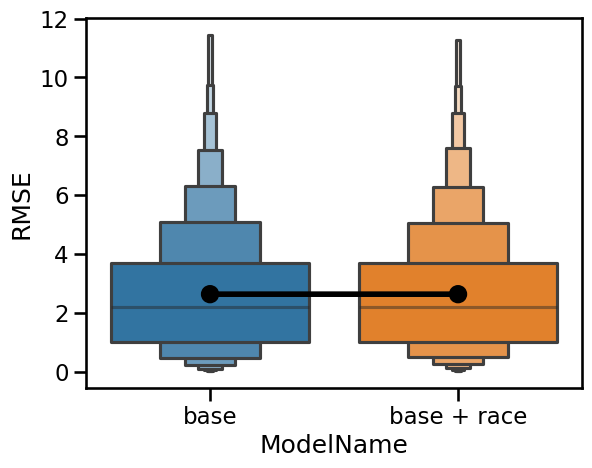

In [612]:
sns.boxenplot(data=full_results, x="ModelName", y="RMSE", showfliers=False)
sns.pointplot(data=full_results, x="ModelName", y="RMSE", color="k")

<Axes: xlabel='ModelName', ylabel='Adjusted R-squared'>

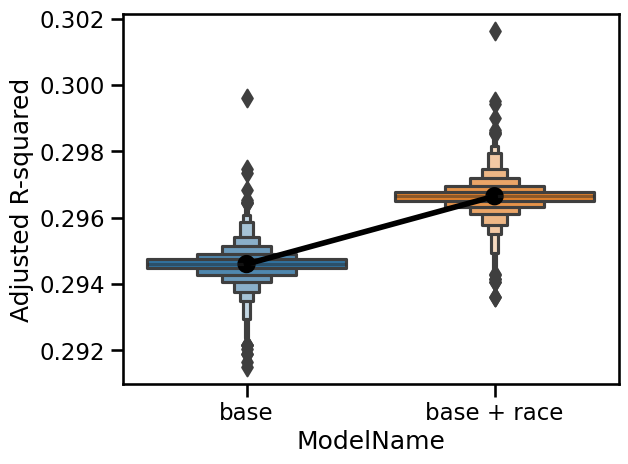

In [613]:
sns.boxenplot(data=full_results, x="ModelName", y="Adjusted R-squared")
sns.pointplot(data=full_results, x="ModelName", y="Adjusted R-squared", color="k")

In [619]:
# Separate the MSE values for the two model names
model1_mse = full_results[full_results["ModelName"] == "base"]["RMSE"]
model2_mse = full_results[full_results["ModelName"] == "base + race"]["RMSE"]

model1_r2 = full_results[full_results["ModelName"] == "base"]["R-squared"]
model2_r2 = full_results[full_results["ModelName"] == "base + race"]["R-squared"]

# Perform t-test to compare the MSE for the two model names
t_stat, p_value = ttest_ind(model1_mse, model2_mse)
t_stat2, p_value2 = ttest_ind(model1_r2, model2_r2)

# Print the t-statistic and p-value
print("MSE T-Statistic:", t_stat)
print("MSE P-Value:", p_value)

print("R2 T-Statistic:", t_stat2)
print("R2 P-Value:", p_value2)

MSE T-Statistic: 0.0073833408909730735
MSE P-Value: 0.9941093837494086
R2 T-Statistic: -189.76305322704985
R2 P-Value: 0.0
